In [77]:
import torch
from torch import nn
from torch.utils.data import TensorDataset, DataLoader

from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder

import numpy as np
import matplotlib.pyplot as plt


In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)


cuda


In [16]:
X, y = fetch_openml(
    "mnist_784", version=1, return_X_y=True, as_frame=False, parser="pandas"
)

X = np.divide(X, 255)

In [17]:
class MLP(nn.Module):
  def __init__(self, input_size, hidden_layer_size, output_size):
    super(MLP, self).__init__()
    self.fc1 = nn.Linear(input_size, hidden_layer_size)
    self.fc2 = nn.Linear(hidden_layer_size, output_size)

  def forward(self, x):
    x = self.fc1(x)
    x = nn.functional.relu(x)
    x = self.fc2(x)
    x = nn.functional.softmax(x)
    return x




In [83]:
nepoch = 100
batch_size = 256

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

input_size = X_train.shape[-1]
hidden_layer_size = 100
output_size = np.unique(y_train).shape[0]

encoder = OneHotEncoder()
y_train = encoder.fit_transform(y_train.reshape(-1, 1)).toarray()
y_test = encoder.transform(y_test.reshape(-1, 1)).toarray()

train_data = TensorDataset(torch.Tensor(X_train).to(device), torch.Tensor(y_train).to(device))
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)




In [32]:
mlp = MLP(input_size, hidden_layer_size, output_size)
mlp.to(device)


MLP(
  (fc1): Linear(in_features=784, out_features=100, bias=True)
  (fc2): Linear(in_features=100, out_features=10, bias=True)
)

In [33]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(mlp.parameters(), lr=0.01)


In [34]:
loss_history = []
for i in range(nepoch):
  loss_epoch_history = []
  for x_batch, y_batch in train_loader:
    optimizer.zero_grad()
    y_pred = mlp(x_batch)
    loss = loss_fn(y_pred, y_batch)
    loss_epoch_history.append(loss.item())
    loss.backward()
    optimizer.step()
  print('Epoch : {}  Loss : {}'.format(i, np.mean(loss_epoch_history)))
  loss_history.append(np.mean(loss_epoch_history))


<ipython-input-17-89502747e2b4>:11: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  x = nn.functional.softmax(x)


Epoch : 0  Loss : 1.5737618235148252
Epoch : 1  Loss : 1.5158361000557468
Epoch : 2  Loss : 1.5025232393447667
Epoch : 3  Loss : 1.4971138140926623
Epoch : 4  Loss : 1.4933960557528283
Epoch : 5  Loss : 1.4904872843119652
Epoch : 6  Loss : 1.4893919452684654
Epoch : 7  Loss : 1.4869990969357425
Epoch : 8  Loss : 1.4860052861035142
Epoch : 9  Loss : 1.4852718016872668
Epoch : 10  Loss : 1.4845810323001043
Epoch : 11  Loss : 1.4839182749186477
Epoch : 12  Loss : 1.485764645550349
Epoch : 13  Loss : 1.4837594130267835
Epoch : 14  Loss : 1.4819491671644933
Epoch : 15  Loss : 1.482801501609419
Epoch : 16  Loss : 1.481742611758785
Epoch : 17  Loss : 1.48176139021573
Epoch : 18  Loss : 1.481726505440664
Epoch : 19  Loss : 1.4808000821501153
Epoch : 20  Loss : 1.4810359717504074
Epoch : 21  Loss : 1.4829489041681159
Epoch : 22  Loss : 1.4804903459331216
Epoch : 23  Loss : 1.4810104898121803
Epoch : 24  Loss : 1.479757721021295
Epoch : 25  Loss : 1.479187403639702
Epoch : 26  Loss : 1.481185599

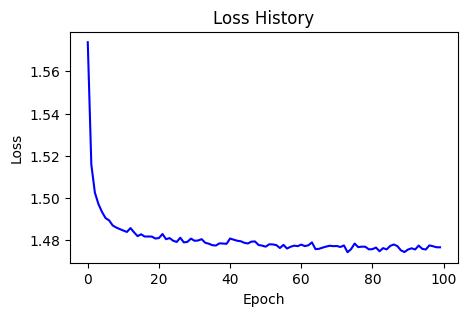

In [36]:
plt.figure(figsize=(5,3))
plt.plot(loss_history, color='blue')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss History')
plt.show()


In [98]:

def evaluate_model(model, data_loader):
  model.eval()
  correct_predictions = 0
  total_predictions = 0
  for x_batch, y_batch in data_loader:
    y_pred = model(x_batch)
    correct_predictions += (torch.argmax(y_pred, dim=1) == torch.argmax(y_batch, dim=1)).sum()
    total_predictions += y_batch.shape[0]
  return correct_predictions / total_predictions

test_data = TensorDataset(torch.Tensor(X_test).to(device), torch.Tensor(y_test).to(device))
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)
print('Test accuracy: {}'.format(evaluate_model(mlp, test_loader)))


<ipython-input-17-89502747e2b4>:11: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  x = nn.functional.softmax(x)


Test accuracy: 0.9673571586608887
